In [11]:
!pip install qibo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Quantum Machine Learning applications using Qibo

## How to write a VQE?

Qibo provides functionality to optimize a Variational Eigensolver. This includes a VQE model that handles optimization and Hamiltonians which can be used to define the loss function. In the following example we optimize a VQE to find the ground state of the Heisenberg XXZ model

$$H = \sum _{i = 1}^N \left (X_i X_{i + 1} + Y_i Y_{i + 1} + \delta Z_i Z_{i + 1}\right )$$


In [12]:
import numpy as np
from qibo import gates, models, hamiltonians

nqubits = 4 # number of qubits in the system
nlayers = 2 # number of layers in the circuit ansatz

# Define problem Hamiltonian
hamiltonian = hamiltonians.XXZ(nqubits)

# Define variational circuit ansatz
circuit = models.Circuit(nqubits)
pairs = list((i, i + 1) for i in range(0, nqubits - 1, 2))
for l in range(nlayers):
    circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))
    circuit.add((gates.CZ(q, q+1) for q in range(0, nqubits-1, 2)))
    circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))
    circuit.add((gates.CZ(i, i + 1) for i in range(1, nqubits - 2, 2)))
    circuit.add(gates.CZ(0, nqubits - 1)) 
circuit.add((gates.RY(i, theta=0) for i in range(nqubits)))

# Define VQE model
vqe = models.VQE(circuit, hamiltonian)

In [14]:
# Calculate exact ground state energy using exact diagonalization
target_energy = np.real(np.min(hamiltonian.eigenvalues()))

# Optimize the VQE model
initial_parameters = np.random.uniform(0, 2 * np.pi, 2 * nqubits * nlayers + nqubits)
best_energy, params, _ = vqe.minimize(initial_parameters, method="BFGS", 
                                   options={'disp': True, "maxiter": 100}, 
                                   compile=False)

print()
print("Target energy:", target_energy)
print("Minimum energy obtained:", best_energy)

Optimization terminated successfully.
         Current function value: -6.744563
         Iterations: 25
         Function evaluations: 630
         Gradient evaluations: 30

Target energy: -6.744562646538029
Minimum energy obtained: -6.7445626465370445


## How to write a custom variational circuit optimization?

Similarly to the VQE, a custom implementation of a Variational Quantum Circuit (VQC) model can be achieved by defining a custom loss function and calling the qibo.optimizers.optimize() method.

In [15]:
import numpy as np
from qibo import models, gates
from qibo.optimizers import optimize

# custom loss function, computes fidelity
def myloss(parameters, circuit, target):
    circuit.set_parameters(parameters)
    final_state = circuit().state(numpy=True)
    return 1 - np.abs(np.conj(target).dot(final_state))**2

nqubits = 6
nlayers  = 2

# Create variational circuit
c = models.Circuit(nqubits)
for l in range(nlayers):
    c.add((gates.RY(q, theta=0) for q in range(nqubits)))
    c.add((gates.CZ(q, q+1) for q in range(0, nqubits-1, 2)))
    c.add((gates.RY(q, theta=0) for q in range(nqubits)))
    c.add((gates.CZ(q, q+1) for q in range(1, nqubits-2, 2)))
    c.add(gates.CZ(0, nqubits-1))
c.add((gates.RY(q, theta=0) for q in range(nqubits)))

# Optimize starting from a random guess for the variational parameters
x0 = np.random.uniform(0, 2*np.pi, 2*nqubits*nlayers + nqubits)
data = np.random.normal(0, 1, size=2**nqubits)

# perform optimization
best, params, extra = optimize(myloss, x0, args=(c, data), method='BFGS', options={'maxiter' : 100, 'disp': True})


# set final solution to circuit instance
c.set_parameters(params)

Optimization terminated successfully.
         Current function value: -43.775640
         Iterations: 68
         Function evaluations: 2449
         Gradient evaluations: 79


## Variational Quantum Classifier

Using Quantum Machine Learning it is possibile to build a classifier.


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from qibo.models import Circuit
from qibo import gates
from qibo.optimizers import optimize
import qibo

Lets assume that we want to solve the following classify a set points whether the point lies inside or outside a circle.

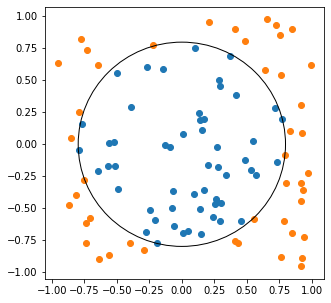

In [17]:
def create_dataset(num):
    '''Creates and lables the dataset of random points in a plane in/out of a circle of half area.
    Args:
        num (int): number of random points to generate.
        
    Returns:
        [data, labels] (np.array): (x, y) coordinates of points in a plane with [0, 1] labels for 
                                inside/outside the circle.
    
    '''
    data = (-1 + 2*np.random.rand(num, 2))
    labels = []
    for x in data:
        r = x[0]**2+x[1]**2
        if r <= 2/np.pi:
            labels.append(0)
        else:
            labels.append(1)
    return [data, np.array(labels)]


def plot_set(dataset):
    '''Plots a given dataset with the corresponding circle with different colors for labelled in/out.
    Args:
        dataset (np.array): (x, y) coordinates of points in a plane with [0, 1] labels for 
                                inside/outside the circle.
    Returns:
        plot of the dataset points color coded whether labelled inside or outside the circle.
    
    '''
    x_in = []
    y_in = []
    x_out = []
    y_out = []
    for i in range(len(dataset[0])):
        if dataset[1][i] == 0:
            x_in.append(dataset[0][i][0])
            y_in.append(dataset[0][i][1])
        else:
            x_out.append(dataset[0][i][0])
            y_out.append(dataset[0][i][1])
    fig, ax = plt.subplots(figsize=(5, 5))
    circle = plt.Circle((0, 0), np.sqrt(2 / np.pi), color='black', fill=False, zorder=10)
    ax.add_artist(circle)
    ax.scatter(x_in, y_in)
    ax.scatter(x_out, y_out)
    plt.show()

plot_set(create_dataset(100))

We can solve this classification problem by using a quantum circuit with a single qubit.

In [18]:
def ansatz(layers):
    '''Create the variational quantum circuit to optimize.
    Args:
        layers (int): number of layers for the variational circuit.
        
    Returns:
        c (qibo.models.Circuit): ansatz circuit with parameterized gates.
    
    '''
    c = Circuit(1)
    for l in range(layers):
        c.add(gates.RY(0, theta=0))
        c.add(gates.RZ(0, theta=0))
    c.add(gates.M(0))
    return c

In [19]:
def circuit(c, params, x):
    '''Sets the parameters to the variational circuit with a given input x.
    Args:
        c (qibo.models.Circuit): ansatz circuit with parameterized gates.
        params (np.array): variational parameters to optimize.
        x (np.array): (x, y) points on the plane of the coordinate to classify.
        
    Returns:
        c (qibo.models.Circuit): circuit with the set optmization parameters.
    
    '''
    c_params = []
    for i in range(0, len(params), 4):
        c_params.append(params[i]*x[0]+params[i+1])
        c_params.append(params[i+2]*x[1]+params[i+3])
    c.set_parameters(c_params)
    return c


def cost_one(params, c, x, label):
    '''Cost function for a single coordinate.
    Args:
        params (np.array): variational parameters to optimize.
        c (qibo.models.Circuit): ansatz circuit with parameterized gates.
        x (np.array): (x, y) points on the plane of the coordinate to classify.
        label (int): known location of the coordinate. 0 for inside the circle, 1 for inside.
        
    Returns:
        cost (float): value that characterizes how close the classification was to the optimial.
    
    '''
    cir = circuit(c, params, x)
    probs = cir(nshots=100).probabilities(qubits=[0])
    cost = .5*(1-(probs[label]))**2
    return cost


def cost_all(params, c, training_set):
    '''Cost function for all the coordinates of the training set.
    Args:
        params (np.array): variational parameters to optimize.
        c (qibo.models.Circuit): ansatz circuit with parameterized gates.
        training_set (np.array): (x, y) coordinates of points in a plane with [0, 1] labels for 
                                 inside/outside the circle.
    
    Returns:
        cost (float): combined cost function of how close the overall classification was.
        
    '''
    cost = 0
    for x, label in zip(training_set[0], training_set[1]):
        cost += cost_one(params, c, x, label)
    cost /= len(training_set[0])
    return cost


def train(training_set, c, layers, method='L-BFGS-B'):
    '''Train a given set of coordinates with a 1 qubit variational circuit.
    Args:
        training_set (np.array): (x, y) coordinates of points in a plane with [0, 1] labels for 
                                 inside/outside the circle.
        c (qibo.models.Circuit): ansatz circuit with parameterized gates.
        layers (int): number of layers for the variational circuit.
        method (str): optimization scheme to use.
        
    Returns:
        parameters (np.array): optimized parameters for classification.
        
    {'fun': r[1], 'x': r[0], 'nfev': r[2], 'nit': r[4], 'xmean': r[5], 'stds': r[6]}
    
    '''
    np.random.seed(0)
    init = np.random.rand(4*layers)
    result, parameters, extra = optimize(cost_all, init, args=(c, training_set),
                                         method='L-BFGS-B', options={'maxiter': 30})
    return parameters

In [20]:
qibo.set_backend('numpy')
layers = 4
train_num = 200
test_num = 1000
training_set = create_dataset(train_num)

[Qibo 0.1.8|INFO|2022-10-03 19:10:35]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


In [21]:
# Lets create our circuit
c = ansatz(layers)

print(c.draw())

q0: ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─M─


In [22]:
params = train(training_set, c, layers)

Lets evaluate the performance on a test set.

In [25]:
def evaluate(c, params, test_set):
    '''Evaluation of the training set with given parameters.
    Args:
        c (qibo.models.Circuit): ansatz circuit with parameterized gates.
        params (np.array): optimized parameters.
        test_set (np.array): (x, y) coordinates of points in a plane.
    
    Returns:
        guess (np.array): guesses of the classifier based on the output of the quantum circuit.
    
    '''
    guess = []
    for x in test_set:
        cir = circuit(c, params, x)
        probs = cir(nshots=100).probabilities(qubits=[0])
        guess.append(np.argmax(probs))
    return np.array(guess)


def accuracy(guess, test_labels):
    '''Accuracy of the test set fivent he known labels of the coordinates.
    Args:
        guess (np.array): guesses of the classifier based on the output of the quantum circuit.
        test_labels (int): known location of the coordinates. 0 for inside the circle, 1 for inside.
        
    Returns:
        accuracy (float): percentage of the test set that has been labelled correctly.
        
    '''
    correct = guess==test_labels
    return np.sum(correct)/len(correct)

In [26]:
test_set = create_dataset(test_num)
guess = evaluate(c, params, test_set[0])
acc = accuracy(guess, test_set[1])
print(f'Accuracy reached for the test set: {acc*100}%')


Accuracy reached for the test set: 92.10000000000001%


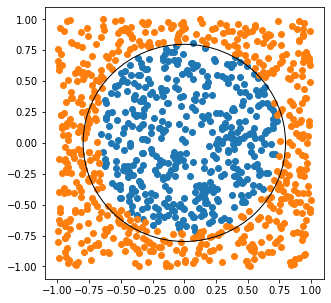

In [27]:
plot_set([test_set[0], guess])

## Exercise 
Modify the `create_dataset` and try to solve other classification problems.
